# X3D (eXpanded 3D) Implementation - Design Alternative 1

`Warning:` Do not run all the code, read the notes first before running them as they may reduce your device's memory when not careful, leading to a kernel crash or Out-Of-Memory (OOM) Error, sige ka magla-lag yang pc mo

`Remarks`: Yeyyyyy panalo raw toh sa Sensiitivity Analysis

**Local System Specifications used to train the model:** <br>
| Component  | Device   |
| :------------- | :--------------- | 
| CPU   | AMD Ryzen 5 5600x     | 
| GPU   | Nvidia GeForce RTX 3070  8GB   | 
| RAM   | 32 GB     | 


`Note`: Implementation is taken from [Video classification with a 3D convolutional neural network](https://www.tensorflow.org/tutorials/video/video_classification)

## Create the dataset

#### Import Libraries and Configure Device

In [25]:
## Uncomment if you are running on colab

#!pip install keras-tuner imageio opencv-python tqdm seaborn scikit-learn
#!pip install -q git+https://github.com/tensorflow/docs

#!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
#!unrar x UCF101.rar

In [1]:
from tqdm import tqdm
import random
import pathlib
import itertools
import collections 
import os
import time

import shutil
import cv2
import mediapipe as mp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, average_precision_score

import torch
import torchvision.transforms as T
from PIL import Image
from pytorchvideo.data.encoded_video import EncodedVideo
from torch.utils.data import Dataset, DataLoader

#### Visualize the data first

In [2]:
def visulize_data(fil_dir):
    """ 
    Let's you visualize the video

    Args:
        fil_dir: Directory of files

    Returns:
        Plot of videos along with the labels

    """

    plt.figure(figsize=(20, 20))
    all_class_names = os.listdir(path=fil_dir)
    random_range = random.sample(range(len(all_class_names)),
                                  len(all_class_names)-random.randrange(1, len(all_class_names)))

    for counter, rand_idx in enumerate(random_range, 1):
        selected_class_name = all_class_names[rand_idx]
        video_files_names_list = os.listdir(f'{fil_dir}/{selected_class_name}')
        selected_video_file_name = random.choice(video_files_names_list)

        video_reader = cv2.VideoCapture(f'{fil_dir}/{selected_class_name}/{selected_video_file_name}')
        _, frame = video_reader.read()
        video_reader.release()

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)

        plt.subplot(5, 4, counter)
        plt.imshow(rgb_frame)
        plt.axis('off')

#### Loading of dataset

In [3]:
## Define the dimensions of frames in the set of frames created (Default params muna)
SIZE = 224
SEQUENCE_LENGTH = 10 # small frame raw para small memory at computation ang gawin, ndi kakakayanin ng mga nasa 16GB lang
LABELS = sorted(['BarbellCurl', 'Deadlift', 'Squat', 'LateralRaises', 'OverheadPress'
          ]) 

- `Note`: This can be changed later on once model is okay

In [4]:
def split_dataset(dataset_dir, 
                  splits={"train": 0.7, "val": 0.15, "test": 0.15}, 
                  seed=42, 
                  selected_classes=None):
    """
    Split the video dataset into train, validation, and test sets and save to subdirectories.
    Ensures no data duplication across splits.
    """
    random.seed(seed)
    
    # Convert dataset directory to Path object
    dataset_dir = pathlib.Path(dataset_dir)
    splits_dirs = ["train", "val", "test"]

    # Remove existing split directories to avoid data overlap
    for split in splits_dirs:
        split_dir = dataset_dir / split
        if split_dir.exists():
            shutil.rmtree(split_dir)

    # Iterate over each class folder in the dataset
    class_dirs = [f for f in dataset_dir.iterdir() if f.is_dir()]
    
    # Filter classes if `selected_classes` is provided
    if selected_classes:
        class_dirs = [f for f in class_dirs if f.name in selected_classes]
    
    for class_dir in tqdm(class_dirs, desc="Processing classes", unit="class"): # May loading yan :)
        print(f"\nProcessing class: {class_dir.name}")
        
        # Get a list of video files in the class directory
        video_files = [f for f in class_dir.iterdir() if f.is_file()]
        
        random.shuffle(video_files)
        
        num_videos = len(video_files)
        train_end = int(splits["train"] * num_videos)
        val_end = train_end + int(splits["val"] * num_videos)
        
        # Split the video files into train, val, and test 
        train_files = video_files[:train_end]
        val_files = video_files[train_end:val_end]
        test_files = video_files[val_end:]
        
        # Move files to directories (tran, val, test)
        for split, files in zip(splits_dirs, [train_files, val_files, test_files]):
            split_dir = dataset_dir / split / class_dir.name
            split_dir.mkdir(parents=True, exist_ok=True)  # Create the class folder in the split directory
            
            for file in tqdm(files, desc=f"Moving files to {split}/{class_dir.name}", unit="file"):
                shutil.move(str(file), str(split_dir / file.name))
    
    print("\nDataset split complete!")

In [5]:
## File path
file_path = './PD_Dataset/' 

In [6]:
## Split the dataset, if na-run na ng isang beses wag na i-run ule, dahil sa code na hindi pa naayos, mawawala lahat yan since na split na si dataset
#split_dataset(file_path, splits={"train": 0.7, "val": 0.15, "test": 0.15}, selected_classes=LABELS) 

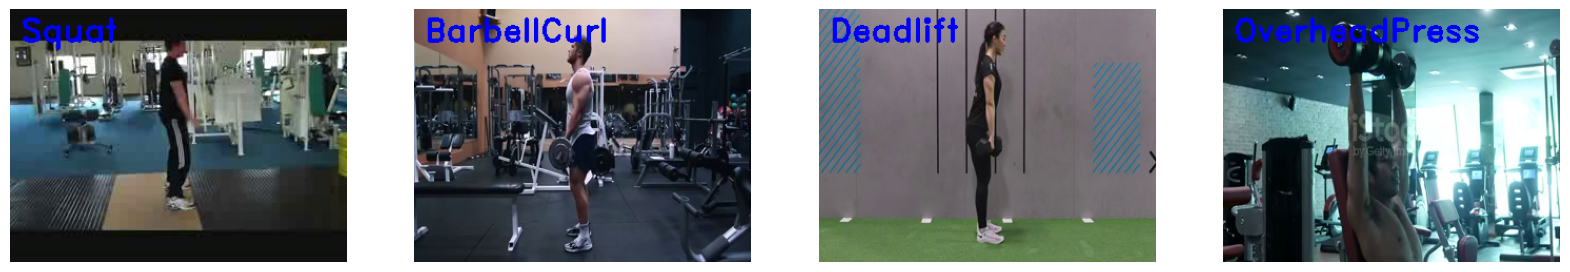

In [7]:
visulize_data(file_path + 'train/')

In [8]:
## Creates a path to the dataset
dataset_paths = {'train':pathlib.PosixPath(f'{file_path}train'),
                    'val':pathlib.PosixPath(f'{file_path}val'),
                    'test':pathlib.PosixPath(f'{file_path}test')}

#### Pre-Processing of Video Datasets

In [15]:
class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None, frame_height=224, frame_width=224, sequence_length=30):
        """
        Args:
            root_dir (str): Root directory of the dataset, containing subdirectories for each label.
            transform (callable, optional): Optional transform to be applied on a video sample.
            frame_height (int): Height of the frames after resizing.
            frame_width (int): Width of the frames after resizing.
            sequence_length (int): Number of frames to use from each video.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.sequence_length = sequence_length
        
        self.video_paths = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        # Collect video paths and corresponding labels
        self._prepare_data()

        # Debugging: Check if video_paths and labels are populated
        print(f"Total videos found: {len(self.video_paths)}")
        print(f"Total labels: {len(self.labels)}")
        print(f"Class to index mapping: {self.class_to_idx}")
        print(f"Video paths: {self.video_paths[:5]}")  # Print first 5 video paths for inspection

    def _prepare_data(self):
        """
        Traverse the root directory and collect video paths and labels.
        """
        for label_idx, label_folder in enumerate(os.listdir(self.root_dir)):
            label_path = os.path.join(self.root_dir, label_folder)
            if os.path.isdir(label_path):
                # Create a mapping from label name to label index
                self.class_to_idx[label_folder] = label_idx
                self.idx_to_class[label_idx] = label_folder

                # Collect video paths for each label
                for video_name in os.listdir(label_path):
                    video_path = os.path.join(label_path, video_name)
                    if os.path.isfile(video_path) and video_path.endswith('.avi'):  
                        self.video_paths.append(video_path)
                        self.labels.append(label_idx)

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        
        frames = self.load_video(video_path)
        
        if self.transform:
            frames = self.transform(frames)
        
        return torch.tensor(frames), torch.tensor(label)

    def load_video(self, video_path):
        """
        Load the video, extract frames, resize them to the target size, and apply dynamic frame skipping.
        """
        cap = cv2.VideoCapture(video_path)
        
        # Get the total number of frames in the video
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Calculate the frame skip dynamically
        frame_skip = total_frames // self.sequence_length
        
        frames = []
        frame_count = 0
        
        while len(frames) < self.sequence_length and cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Skip frames based on the dynamic frame_skip parameter
            if frame_count % frame_skip == 0:
                frame = cv2.resize(frame, (self.frame_width, self.frame_height))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            
            frame_count += 1
        
        cap.release()

        # If video is shorter than the desired sequence, pad with zeros
        if len(frames) < self.sequence_length:
            frames.extend([np.zeros((self.frame_height, self.frame_width, 3))] * (self.sequence_length - len(frames)))
        
        # Convert frames to numpy array and normalize
        frames = np.array(frames).astype(np.float32) / 255.0

        # Convert the frames to CxTxHxW format (Channels, Time, Height, Width)
        frames = np.transpose(frames, (3, 0, 1, 2))  # Change to (C, T, H, W)
        
        return frames

#### Split and Generate the datasets

In [18]:
# Instantiate the dataset
train_dataset = VideoDataset(
    root_dir=dataset_paths['train'],
    transform=None,  # You can apply any transforms if necessary
    frame_height=224,
    frame_width=224,
    sequence_length=10,
)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

Total videos found: 305
Total labels: 305
Class to index mapping: {'BarbellCurl': 0, 'Deadlift': 1, 'LateralRaises': 2, 'OverheadPress': 3, 'Squat': 4}
Video paths: ['PD_Dataset/train/BarbellCurl/barbell_curl 10.avi', 'PD_Dataset/train/BarbellCurl/barbell_curl 100.avi', 'PD_Dataset/train/BarbellCurl/barbell_curl 102.avi', 'PD_Dataset/train/BarbellCurl/barbell_curl 103.avi', 'PD_Dataset/train/BarbellCurl/barbell_curl 106.avi']


In [30]:
# Instantiate the dataset
test_dataset = VideoDataset(
    root_dir=dataset_paths['test'],
    transform=None,  # You can apply any transforms if necessary
    frame_height=224,
    frame_width=224,
    sequence_length=10,
)

test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Total videos found: 70
Total labels: 70
Class to index mapping: {'BarbellCurl': 0, 'Deadlift': 1, 'LateralRaises': 2, 'OverheadPress': 3, 'Squat': 4}
Video paths: ['PD_Dataset/test/BarbellCurl/barbell_curl 104.avi', 'PD_Dataset/test/BarbellCurl/barbell_curl 108.avi', 'PD_Dataset/test/BarbellCurl/barbell_curl 109.avi', 'PD_Dataset/test/BarbellCurl/barbell_curl 28.avi', 'PD_Dataset/test/BarbellCurl/barbell_curl 29.avi']


- `Note`: Datasets can be configured to increase performance when loading and training it in a model, this is called *prefetch*. The *prefetch* is efficient when loading the dataset in the memory, making it faster; it also helps with utilizing the GPU, making it train faster.

#### Plotting Functions for later

In [21]:
def plot_history(train_loss, val_loss, train_acc, val_acc):
    """
        Plotting training and validation learning curves.
        Args: 
         history: model history with all the metric measures
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18.5, 10.5))

    # Loss plot
    ax1.plot(train_loss, label="Train Loss")
    ax1.plot(val_loss, label="Validation Loss")
    ax1.set_title("Loss")
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Epoch")
    ax1.legend()

    # Accuracy plot
    ax2.plot(train_acc, label="Train Accuracy")
    ax2.plot(val_acc, label="Validation Accuracy")
    ax2.set_title("Accuracy")
    ax2.set_ylabel("Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.legend()

    plt.show()

In [22]:
def get_actual_predicted_labels(dataloader, trained_model, device='cuda'):
    """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
        dataloader: An iterable data loader with features and labels.
        trained_model: The trained PyTorch model.
        device: The device to run the model on ('cuda' or 'cpu').

    Returns:
        actual (torch.Tensor): Ground truth labels.
        predicted (torch.Tensor): Predicted labels.
    """
    actual = []
    predicted = []

    trained_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get predictions
            outputs = trained_model(inputs)
            preds = torch.argmax(outputs, dim=1)
            
            # Collect ground truth and predictions
            actual.append(labels)
            predicted.append(preds)

    # Concatenate all batches into single tensors
    actual = torch.cat(actual, dim=0)
    predicted = torch.cat(predicted, dim=0)

    return actual, predicted



def plot_confusion_matrix(y_actual, y_pred, labels, ds_type):
    """
    Plot a confusion matrix.

    Args:
        y_actual (list or array): Ground truth labels.
        y_pred (list or array): Predicted labels.
        labels (list): List of class names.
        ds_type (str): Type of dataset (e.g., "Train", "Validation").

    Returns:
        None: Displays the confusion matrix plot.
    """
    cm = confusion_matrix(y_actual, y_pred)
    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    ax.set_title(f'Confusion Matrix for {ds_type}')
    ax.set_xlabel('Predicted Action')
    ax.set_ylabel('Actual Action')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

In [23]:
def calculate_classification_metrics(y_actual, y_pred, labels):
    """
    Calculate precision, recall, and F1-score for each class.

    Args:
        y_actual (list or array): Ground truth labels.
        y_pred (list or array): Predicted labels.
        labels (list): List of class names.

    Returns:
        dict: Dictionary containing precision, recall, and F1-score per class.
    """
    report = classification_report(y_actual, y_pred, target_names=labels, output_dict=True)
    precision = {label: report[label]['precision'] for label in labels}
    recall = {label: report[label]['recall'] for label in labels}
    f1_scores = {label: report[label]['f1-score'] for label in labels}
    return precision, recall, f1_scores

In [24]:
def calculate_f1_score(y_actual, y_pred, labels, average='macro'):
    """
    Calculate F1-Score for each class and optionally a macro-average.

    Args:
        y_actual (list or array): Ground truth labels.
        y_pred (list or array): Predicted labels.
        labels (list): List of class names.
        average (str): 'macro' to return average F1-score, 'none' for per-class F1-scores.

    Returns:
        dict: F1-scores per class and/or macro-average F1-score.
    """
    cm = confusion_matrix(y_actual, y_pred, labels=range(len(labels)))
    tp = np.diag(cm)  # True positives (diagonal elements)
    precision = tp / (np.sum(cm, axis=0) + 1e-7)  # Avoid division by zero
    recall = tp / (np.sum(cm, axis=1) + 1e-7)

    f1_scores = {label: 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-7)
                 for i, label in enumerate(labels)}

    if average == 'macro':
        macro_f1 = np.mean(list(f1_scores.values()))
        return f1_scores, macro_f1

    return f1_scores

In [25]:
def calculate_map(y_actual, y_pred, num_classes):
    """
    Calculate Mean Average Precision (mAP) for multi-class classification.

    Args:
        y_actual (list or array): Ground truth labels (class indices).
        y_pred (numpy.ndarray): Predicted probabilities (e.g., softmax outputs from the model).
        num_classes (int): Number of classes in the dataset.

    Returns:
        float: Mean Average Precision score.
    """
    y_actual_one_hot = np.eye(num_classes)[y_actual]  # Convert to one-hot
    aps = []
    for i in range(num_classes):
        ap = average_precision_score(y_actual_one_hot[:, i], y_pred[:, i])
        aps.append(ap)

    return np.mean(aps)

In [26]:
def plot_precision_recall_curve(y_actual, y_pred, labels):
    """
    Plot Precision-Recall curves and calculate AUC for each class.

    Args:
        y_actual (list or array): Ground truth labels (class indices).
        y_pred (numpy.ndarray): Predicted probabilities (e.g., softmax outputs from the model).
        labels (list): List of class names.

    Returns:
        dict: Dictionary containing AUC-PR for each class.
    """
    auc_scores = {}
    plt.figure(figsize=(10, 8))

    for i, label in enumerate(labels):
        # Create binary ground truth for the current class
        y_binary = (np.array(y_actual) == i).astype(int)
        precision, recall, _ = precision_recall_curve(y_binary, y_pred[:, i])
        pr_auc = auc(recall, precision)
        auc_scores[label] = pr_auc

        # Plot the precision-recall curve
        plt.plot(recall, precision, label=f'{label} (AUC = {pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return auc_scores

## Model Structuring, HyperTuning, and Training

This Network Architecture is from the paper [X3D: Expanding Architectures for Efficient Video Recognition](https://arxiv.org/abs/2004.04730)

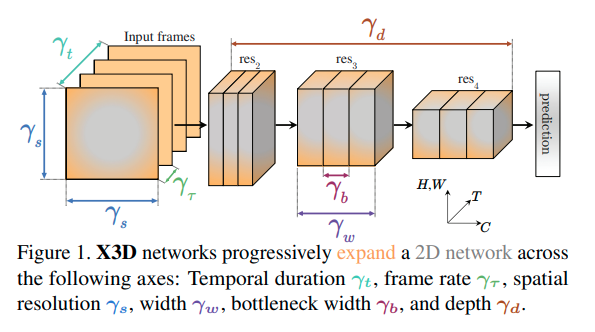

- `Note`: The structure of the is based on the figure above, it will be modified to tailor our project design's specific objectives

#### Network Building and HyperTuning of Parameters

In [33]:
from x3d import create_x3d

model = create_x3d(input_channel=3,
                   input_clip_length=SEQUENCE_LENGTH,
                   input_crop_size=SIZE,
                   model_num_class=len(LABELS),
                   dropout_rate=0.5,
                   width_factor=2.0,
                   depth_factor=2.2,
                   norm=torch.nn.BatchNorm3d,
                   activation=torch.nn.ReLU,


                   )
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


# Training configuration
num_epochs = 50

#### Train the model

In [34]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Scheduler to reduce learning rate on validation loss plateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Tracking variables
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0.0  # Track the best validation accuracy
best_model_state = None  # Save the best model state

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch + 1}/{num_epochs}]")
    
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_dataloader), desc="Training", unit="batch") as pbar: # May loading yan na kasama parang sa keras:)
        for i, (inputs, targets) in enumerate(train_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            # Update tqdm progress
            pbar.set_postfix(loss=f"{loss.item():.4f}")
            pbar.update(1)

    train_loss = running_loss / len(train_dataloader)
    train_acc = correct / total * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    # Add tqdm for validation
    with tqdm(total=len(test_dataloader), desc="Validation", unit="batch") as pbar:
        with torch.no_grad():
            for inputs, targets in test_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

                # Update tqdm progress
                pbar.set_postfix(loss=f"{loss.item():.4f}")
                pbar.update(1)

    val_loss = val_running_loss / len(test_dataloader)
    val_acc = val_correct / val_total * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Adjust learning rate based on validation loss
    scheduler.step(val_loss)

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()

    # Print epoch results
    print(
        f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}"
    )

# Save the best model
if best_model_state:
    torch.save(best_model_state, "x3d_model.pth")
    print(f"\nBest model saved with Validation Accuracy: {best_val_acc:.2f}%")

print("Training complete!")


Epoch [1/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.24batch/s, loss=0.6040]


Train Loss: 1.6904, Train Accuracy: 23.6066, Val Loss: 1.8914, Val Accuracy: 20.0000

Epoch [2/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.21batch/s, loss=0.8111]


Train Loss: 1.5744, Train Accuracy: 31.4754, Val Loss: 1.5099, Val Accuracy: 35.7143

Epoch [3/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.25batch/s, loss=1.1364]


Train Loss: 1.5187, Train Accuracy: 28.1967, Val Loss: 1.4120, Val Accuracy: 32.8571

Epoch [4/50]


Validation: 100%|██████████| 9/9 [00:08<00:00,  1.11batch/s, loss=1.2855]


Train Loss: 1.4277, Train Accuracy: 36.0656, Val Loss: 1.3490, Val Accuracy: 35.7143

Epoch [5/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.14batch/s, loss=1.0410]


Train Loss: 1.4384, Train Accuracy: 36.0656, Val Loss: 1.3349, Val Accuracy: 38.5714

Epoch [6/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.25batch/s, loss=1.1014]


Train Loss: 1.4318, Train Accuracy: 37.3770, Val Loss: 1.2956, Val Accuracy: 40.0000

Epoch [7/50]


Validation: 100%|██████████| 9/9 [00:08<00:00,  1.11batch/s, loss=1.3836]


Train Loss: 1.3968, Train Accuracy: 37.7049, Val Loss: 1.3202, Val Accuracy: 38.5714

Epoch [8/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.24batch/s, loss=0.4770]


Train Loss: 1.3781, Train Accuracy: 40.6557, Val Loss: 1.1897, Val Accuracy: 41.4286

Epoch [9/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.28batch/s, loss=0.7542]


Train Loss: 1.2749, Train Accuracy: 42.2951, Val Loss: 1.2371, Val Accuracy: 42.8571

Epoch [10/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.25batch/s, loss=0.0848]


Train Loss: 1.2843, Train Accuracy: 42.2951, Val Loss: 1.5670, Val Accuracy: 42.8571

Epoch [11/50]


Validation: 100%|██████████| 9/9 [00:08<00:00,  1.12batch/s, loss=1.5533]


Train Loss: 1.2710, Train Accuracy: 43.6066, Val Loss: 1.2714, Val Accuracy: 48.5714

Epoch [12/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.27batch/s, loss=0.0380]


Train Loss: 1.1463, Train Accuracy: 48.5246, Val Loss: 1.2447, Val Accuracy: 50.0000

Epoch [13/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.23batch/s, loss=1.4888]


Train Loss: 1.1737, Train Accuracy: 52.1311, Val Loss: 1.6366, Val Accuracy: 45.7143

Epoch [14/50]


Validation: 100%|██████████| 9/9 [00:08<00:00,  1.11batch/s, loss=2.3081]


Train Loss: 1.1247, Train Accuracy: 51.4754, Val Loss: 1.6303, Val Accuracy: 34.2857

Epoch [15/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.25batch/s, loss=0.3435]


Train Loss: 0.9202, Train Accuracy: 58.0328, Val Loss: 1.1424, Val Accuracy: 54.2857

Epoch [16/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.27batch/s, loss=0.4946]


Train Loss: 0.8834, Train Accuracy: 64.2623, Val Loss: 1.3365, Val Accuracy: 51.4286

Epoch [17/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.24batch/s, loss=0.3028]


Train Loss: 0.8666, Train Accuracy: 66.5574, Val Loss: 1.2945, Val Accuracy: 41.4286

Epoch [18/50]


Validation: 100%|██████████| 9/9 [00:08<00:00,  1.11batch/s, loss=0.9720]


Train Loss: 0.7097, Train Accuracy: 73.4426, Val Loss: 1.4848, Val Accuracy: 47.1429

Epoch [19/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.22batch/s, loss=0.8471]


Train Loss: 0.6821, Train Accuracy: 76.0656, Val Loss: 1.5484, Val Accuracy: 41.4286

Epoch [20/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.26batch/s, loss=0.8160]


Train Loss: 0.5015, Train Accuracy: 79.3443, Val Loss: 1.6207, Val Accuracy: 50.0000

Epoch [21/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.24batch/s, loss=0.6922]


Train Loss: 0.5207, Train Accuracy: 80.9836, Val Loss: 1.8924, Val Accuracy: 38.5714

Epoch [22/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.26batch/s, loss=0.8979]


Train Loss: 0.4985, Train Accuracy: 81.6393, Val Loss: 1.5420, Val Accuracy: 52.8571

Epoch [23/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.26batch/s, loss=0.9181]


Train Loss: 0.3640, Train Accuracy: 91.1475, Val Loss: 1.8648, Val Accuracy: 40.0000

Epoch [24/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.24batch/s, loss=0.7874]


Train Loss: 0.3955, Train Accuracy: 90.4918, Val Loss: 1.7147, Val Accuracy: 54.2857

Epoch [25/50]


Validation: 100%|██████████| 9/9 [00:08<00:00,  1.09batch/s, loss=0.8490]


Train Loss: 0.2610, Train Accuracy: 94.7541, Val Loss: 1.8543, Val Accuracy: 48.5714

Epoch [26/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.20batch/s, loss=0.9623]


Train Loss: 0.3513, Train Accuracy: 91.8033, Val Loss: 2.1866, Val Accuracy: 54.2857

Epoch [27/50]


Validation: 100%|██████████| 9/9 [00:08<00:00,  1.12batch/s, loss=0.5178]


Train Loss: 0.2699, Train Accuracy: 90.4918, Val Loss: 1.9246, Val Accuracy: 52.8571

Epoch [28/50]


Validation: 100%|██████████| 9/9 [00:08<00:00,  1.11batch/s, loss=0.8287]


Train Loss: 0.2977, Train Accuracy: 92.4590, Val Loss: 2.1035, Val Accuracy: 44.2857

Epoch [29/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.16batch/s, loss=1.1057]


Train Loss: 0.2749, Train Accuracy: 95.4098, Val Loss: 1.9673, Val Accuracy: 52.8571

Epoch [30/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.22batch/s, loss=1.0075]


Train Loss: 0.3111, Train Accuracy: 95.0820, Val Loss: 2.2151, Val Accuracy: 50.0000

Epoch [31/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.23batch/s, loss=1.3589]


Train Loss: 0.2651, Train Accuracy: 94.7541, Val Loss: 2.1170, Val Accuracy: 50.0000

Epoch [32/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.19batch/s, loss=1.3242]


Train Loss: 0.2445, Train Accuracy: 97.7049, Val Loss: 2.2153, Val Accuracy: 44.2857

Epoch [33/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.17batch/s, loss=1.0940]


Train Loss: 0.2076, Train Accuracy: 95.7377, Val Loss: 2.2348, Val Accuracy: 54.2857

Epoch [34/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.21batch/s, loss=1.1578]


Train Loss: 0.1724, Train Accuracy: 97.0492, Val Loss: 2.4353, Val Accuracy: 42.8571

Epoch [35/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.21batch/s, loss=0.6231]


Train Loss: 0.1267, Train Accuracy: 98.3607, Val Loss: 2.3746, Val Accuracy: 41.4286

Epoch [36/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.25batch/s, loss=1.2358]


Train Loss: 0.1776, Train Accuracy: 96.3934, Val Loss: 2.3943, Val Accuracy: 40.0000

Epoch [37/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.13batch/s, loss=2.2394]


Train Loss: 0.3261, Train Accuracy: 96.0656, Val Loss: 3.0380, Val Accuracy: 34.2857

Epoch [38/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.20batch/s, loss=1.3182]


Train Loss: 0.1624, Train Accuracy: 94.4262, Val Loss: 2.3707, Val Accuracy: 48.5714

Epoch [39/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.23batch/s, loss=1.0781]


Train Loss: 0.1807, Train Accuracy: 95.7377, Val Loss: 2.4268, Val Accuracy: 44.2857

Epoch [40/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.16batch/s, loss=1.1041]


Train Loss: 0.0874, Train Accuracy: 97.0492, Val Loss: 2.3125, Val Accuracy: 48.5714

Epoch [41/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.18batch/s, loss=1.0495]


Train Loss: 0.1507, Train Accuracy: 98.0328, Val Loss: 2.6637, Val Accuracy: 48.5714

Epoch [42/50]


Validation: 100%|██████████| 9/9 [00:08<00:00,  1.04batch/s, loss=1.3216]


Train Loss: 0.1791, Train Accuracy: 99.0164, Val Loss: 2.4833, Val Accuracy: 44.2857

Epoch [43/50]


Validation: 100%|██████████| 9/9 [00:08<00:00,  1.11batch/s, loss=1.3045]


Train Loss: 0.1526, Train Accuracy: 96.7213, Val Loss: 2.4034, Val Accuracy: 47.1429

Epoch [44/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.17batch/s, loss=0.8536]


Train Loss: 0.2235, Train Accuracy: 96.7213, Val Loss: 2.4776, Val Accuracy: 44.2857

Epoch [45/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.22batch/s, loss=1.3669]


Train Loss: 0.1583, Train Accuracy: 97.3770, Val Loss: 2.3781, Val Accuracy: 47.1429

Epoch [46/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.22batch/s, loss=1.2283]


Train Loss: 0.2718, Train Accuracy: 97.0492, Val Loss: 2.4049, Val Accuracy: 51.4286

Epoch [47/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.17batch/s, loss=1.1107]


Train Loss: 0.0549, Train Accuracy: 98.6885, Val Loss: 2.2301, Val Accuracy: 51.4286

Epoch [48/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.18batch/s, loss=1.6223]


Train Loss: 0.2098, Train Accuracy: 98.3607, Val Loss: 2.3692, Val Accuracy: 47.1429

Epoch [49/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.19batch/s, loss=2.0128]


Train Loss: 0.2311, Train Accuracy: 98.6885, Val Loss: 2.4389, Val Accuracy: 48.5714

Epoch [50/50]


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.18batch/s, loss=1.4499]

Train Loss: 0.1840, Train Accuracy: 96.7213, Val Loss: 2.6136, Val Accuracy: 41.4286
Best model saved with Validation Accuracy: 54.29%
Training complete!


- `Remarks`: Why use more than 100 epochs you ask? Because some [Indian guy on YouTube](https://youtu.be/QmtSkq3DYko?si=V28jCOfot8MeHep6) used 500 epochs to train his Action Recognition model, therefore it is also wise to use the same training scheme. What a chad!

#### Plot the model and get the metrics

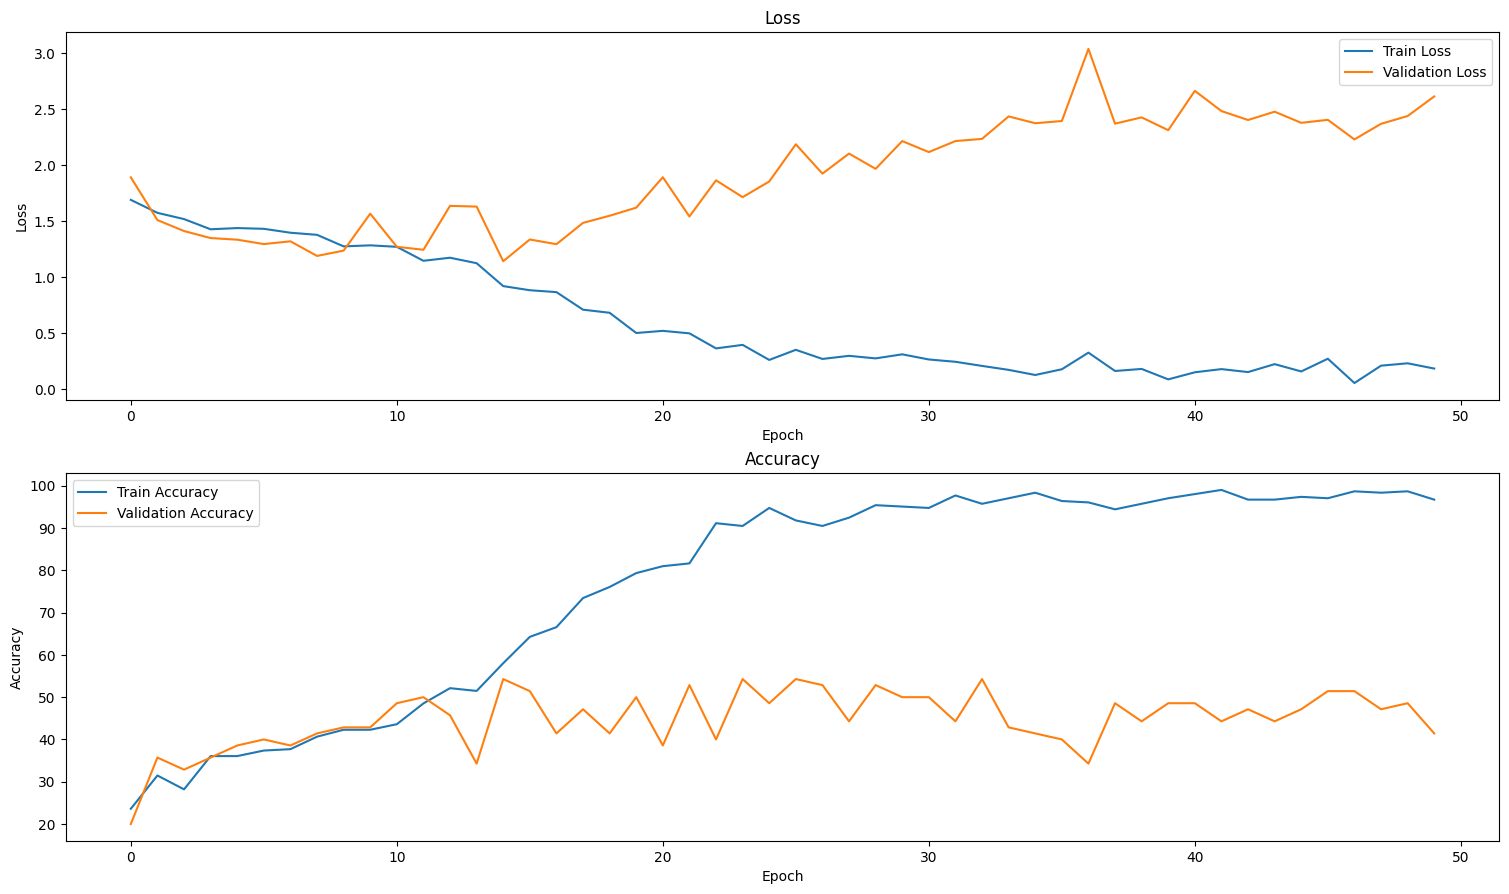

In [35]:
plot_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [36]:
val_dataset = VideoDataset(
    root_dir=dataset_paths['val'],
    transform=None,  # You can apply any transforms if necessary
    frame_height=224,
    frame_width=224,
    sequence_length=10,
)

val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

Total videos found: 65
Total labels: 65
Class to index mapping: {'BarbellCurl': 0, 'Deadlift': 1, 'LateralRaises': 2, 'OverheadPress': 3, 'Squat': 4}
Video paths: ['PD_Dataset/val/BarbellCurl/barbell_curl 14.avi', 'PD_Dataset/val/BarbellCurl/barbell_curl 17.avi', 'PD_Dataset/val/BarbellCurl/barbell_curl 18.avi', 'PD_Dataset/val/BarbellCurl/barbell_curl 22.avi', 'PD_Dataset/val/BarbellCurl/barbell_curl 31.avi']


In [36]:
fg = FrameGenerator(dataset_paths['train'], SEQUENCE_LENGTH, training=True)
labels = list(fg.class_ids_for_name.keys())

In [38]:
actual, predicted = get_actual_predicted_labels(val_dataloader, model)
plot_confusion_matrix(actual, predicted, labels, 'training')

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds, model)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [39]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [ ]:
precision

In [ ]:
recall

## Load Model and Test

In [ ]:
## Load model
load_model = keras.models.load_model('model_X3D.keras',
                                    custom_objects={'SEBlock': SEBlock,
                                                    'X3DBottleneck': X3DBottleneck,
                                                    })

#### Evaluate the Model

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds, load_model)

In [ ]:
f1_score = calculate_f1_score(actual, predicted, labels)
f1_score[1]

In [ ]:
proba = load_model.predict(test_ds)

In [ ]:
MAP = calculate_map(actual, proba, len(labels))
MAP

In [ ]:
plot_precision_recall_curve(actual, proba, labels)

- Ganto si curve kasi may class imbalance, shhh muna wala pa matinong dataset :)

#### Test the Model

In [ ]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

sequence_length = SEQUENCE_LENGTH
resize_shape = (HEIGHT, WIDTH)
file_dir = 'unknown/Deadlift2.mp4'

cap = cv2.VideoCapture(file_dir)
frames = []
predicted_label = ""

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break

    # Process the frame for pose detection
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb_frame)

    # Draw keypoints and connections on the frame
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    # Resize and prepare frame for prediction
    resized_frame = cv2.resize(frame, resize_shape)
    rgb_resized_frame = resized_frame[:, :, ::-1]
    frames.append(rgb_resized_frame)

    # Add predicted activity label to frame
    display_text = f"Activity: {predicted_label}"
    cv2.putText(frame, display_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow('Cam', frame)

    # Perform prediction every `sequence_length` frames
    if len(frames) == sequence_length:
        frames_array = np.array(frames) / 255.0  # Normalize to [0, 1]
        frames_array = np.expand_dims(frames_array, axis=0)  # Shape (1, sequence_length, height, width, 3)

        prediction = load_model.predict(frames_array)

        # Update predicted label
        predicted_index = np.argmax(prediction, axis=1)[0]
        predicted_label = sorted(LABELS)[predicted_index]
        print("Activity:", predicted_label)

        frames = []

    # Exit loop on 'q' key press
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()